In [6]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import assembly_multi_region, assembly_multi_region_pos_maps_tmaze
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
import nelpy as nel
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import glob
import pickle
import itertools
from ripple_heterogeneity.place_cells import maps
from scipy import stats
from scipy.stats import zscore

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

epoch_df = pd.DataFrame()
for basepath in df.basepath.unique():

    epoch_df_ = loading.load_epoch(basepath)
    df_temp_regions = pd.DataFrame()
    df_temp_regions["regions"] = loading.load_brain_regions(basepath).keys()
    epoch_df_["mec"] = df_temp_regions.regions.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").any()
    epoch_df_["pfc"] = df_temp_regions.regions.str.contains("PFC").any()

    epoch_df_["basepath"] = basepath

    epoch_df = pd.concat([epoch_df,epoch_df_],ignore_index=True)

In [3]:
epoch_df.environment.unique()


array(['sleep', 'linear', 'tmaze', 'cheeseboard', 'box', 'wmaze', 'water',
       'unknown', 'open', 'linearOne', 'linearTwo', 'Tmaze', 'wheel',
       'bigSquare', 'Mwheel', 'plus', 'midSquare', 'bigSquarePlus',
       'wheel_home', 'circle', 'ZigZag', 'test'], dtype=object)

In [4]:
epoch_df.query("environment.str.contains('Mwheel|Tmaze|tmaze|wmaze') & (mec|pfc)").basepath.unique()


array(['Z:\\Data\\AYAold\\AYA10\\day12',
       'Z:\\Data\\FujisawaS\\EE\\EE0622fm',
       'Z:\\Data\\FujisawaS\\EE\\EE0627fm',
       'Z:\\Data\\FujisawaS\\EE\\EE0705fm',
       'Z:\\Data\\FujisawaS\\EE\\EE0706fm',
       'Z:\\Data\\FujisawaS\\EE\\EE0708fm',
       'Z:\\Data\\FujisawaS\\EE\\EE0710',
       'Z:\\Data\\FujisawaS\\EE\\EE0711',
       'Z:\\Data\\FujisawaS\\FF\\FF1114',
       'Z:\\Data\\FujisawaS\\FF\\FF1116',
       'Z:\\Data\\FujisawaS\\FF\\FF1119',
       'Z:\\Data\\FujisawaS\\GG\\GG0401',
       'Z:\\Data\\FujisawaS\\GG\\GG0406',
       'Z:\\Data\\Kenji\\ec013.421_447', 'Z:\\Data\\Kenji\\ec013.480_509',
       'Z:\\Data\\Kenji\\ec013.540_561', 'Z:\\Data\\Kenji\\ec013.608_632',
       'Z:\\Data\\Kenji\\ec013.656_674', 'Z:\\Data\\Kenji\\ec013.702_724',
       'Z:\\Data\\Kenji\\ec013.771_777', 'Z:\\Data\\Kenji\\ec013.779_791',
       'Z:\\Data\\Kenji\\ec013.816_835', 'Z:\\Data\\Kenji\\ec013.895_902',
       'Z:\\Data\\Kenji\\ec013.921_927', 'Z:\\Data\\Kenji\\ec014.120_1

In [113]:
results = assembly_multi_region_pos_maps_tmaze.run(r"Z:\Data\AYAold\AYA10\day12")

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [37]:
position_df = loading.load_animal_behavior(r"Z:\Data\AYAold\AYA10\day12")
position_df

time   x   y  linearized units  projected_x  projected_y  \
0           0.0000 NaN NaN         NaN    cm          NaN          NaN   
1           0.0256 NaN NaN         NaN    cm          NaN          NaN   
2           0.0512 NaN NaN         NaN    cm          NaN          NaN   
3           0.0768 NaN NaN         NaN    cm          NaN          NaN   
4           0.1024 NaN NaN         NaN    cm          NaN          NaN   
...            ...  ..  ..         ...   ...          ...          ...   
558869  14307.0464 NaN NaN         NaN    cm          NaN          NaN   
558870  14307.0720 NaN NaN         NaN    cm          NaN          NaN   
558871  14307.0976 NaN NaN         NaN    cm          NaN          NaN   
558872  14307.1232 NaN NaN         NaN    cm          NaN          NaN   
558873  14307.1488 NaN NaN         NaN    cm          NaN          NaN   

             sr  timestamps  speed  acceleration  states   epochs environment  
0       39.0625      0.0000    NaN           0.0     NaN  trial_1       tmaze  
1       39.0625      0.0256    NaN           NaN     NaN  trial_1       tmaze  
2       39.0625      0.0512    NaN           NaN     NaN  trial_1       tmaze  
3       39.0625      0.0768    NaN           NaN     NaN  trial_1       tmaze  
4       39.0625      0.1024    NaN           NaN     NaN  trial_1       tmaze  
...         ...         ...    ...           ...     ...      ...         ...  
558869  39.0625  14307.0464    0.0           0.0     NaN  trial_4       sleep  
558870  39.0625  14307.0720    0.0           0.0     NaN  trial_4       sleep  
558871  39.0625  14307.0976    0.0           0.0     NaN      NaN         NaN  
558872  39.0625  14307.1232    NaN           NaN     NaN      NaN         NaN  
558873  39.0625  14307.1488    NaN           NaN     NaN      NaN         NaN  

[558874 rows x 14 columns]

In [50]:
def find_good_laps(pos, dir_epoch, thres=0.5, binsize=6, min_laps=10):
    """
    find_good_laps: finds good laps in behavior data
        Made to find good laps in nelpy array for replay analysis
    input:
        pos: nelpy analog array with single dim
        dir_epoch: epoch to find good lap
        thres: occupancy threshold for good lap
        binsize: size of bins to calculate occupancy
    output:
        good_laps: epoch array of good laps
    """
    # make bin edges to calc occupancy
    x_edges = np.arange(np.nanmin(pos.data[0]), np.nanmax(pos.data[0]), binsize)
    # initialize occupancy matrix (position x time)
    occ = np.zeros([len(x_edges) - 1, dir_epoch.n_intervals])
    # iterate through laps
    for i, ep in enumerate(dir_epoch):
        # bin position per lap
        occ[:, i], _ = np.histogram(pos[ep].data[0], bins=x_edges)
    # calc percent occupancy over position bins per lap and find good laps
    good_laps = np.where(~((np.sum(occ == 0, axis=0) / occ.shape[0]) > thres))[0]
    # if no good laps, return empty epoch
    if (len(good_laps) == 0) | (len(good_laps) < min_laps):
        dir_epoch = nel.EpochArray()
    else:
        dir_epoch = dir_epoch[good_laps]
    return dir_epoch

In [56]:
np.vstack([position_df.query("epochs=='trial_1' & states==1").timestamps,position_df.query("epochs=='trial_1' & states==1").timestamps])

array([[  76.672 ,   76.6976,   76.7232, ..., 1615.7184, 1615.744 ,
        1615.7696],
       [  76.672 ,   76.6976,   76.7232, ..., 1615.7184, 1615.744 ,
        1615.7696]])

In [59]:
position_df.query("epochs=='trial_1' & states==1").timestamps

2995       76.6720
2996       76.6976
2997       76.7232
3040       77.8240
3041       77.8496
           ...    
62842    1608.7552
62843    1608.7808
63114    1615.7184
63115    1615.7440
63116    1615.7696
Name: timestamps, Length: 22745, dtype: float64

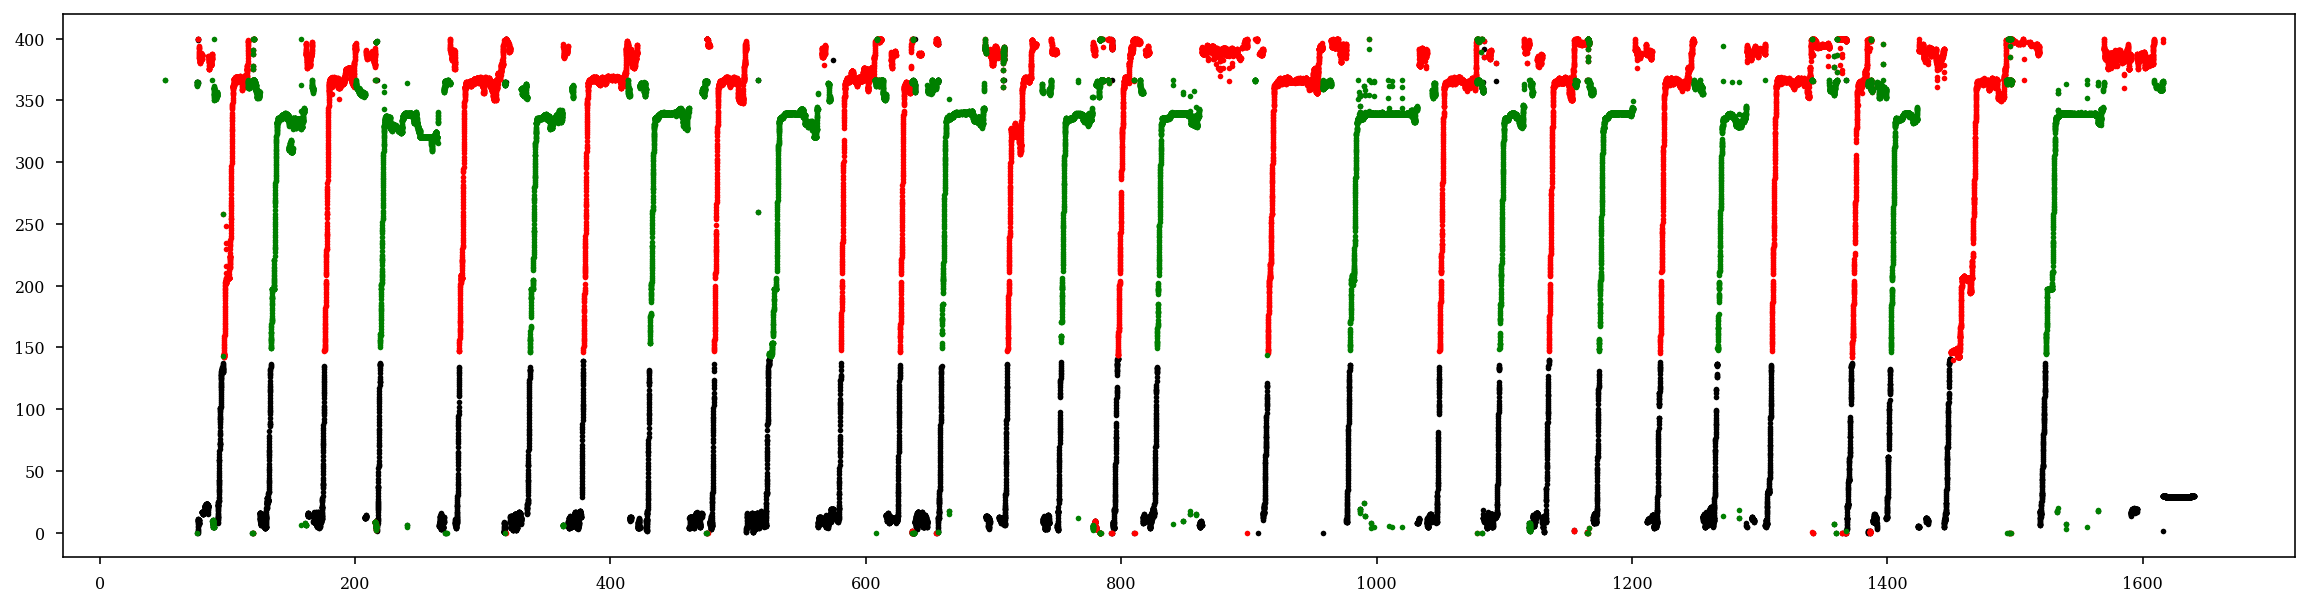

In [72]:
    
state_0_epochs = nel.EpochArray(
    np.vstack(
        [
            position_df.query("epochs=='trial_1' & states==0").timestamps,
            position_df.query("epochs=='trial_1' & states==0").timestamps,
        ]
    ).T
).merge(gap=1)

state_1_epochs = nel.EpochArray(
    np.vstack(
        [
            position_df.query("epochs=='trial_1' & states==1").timestamps,
            position_df.query("epochs=='trial_1' & states==1").timestamps,
        ]
    ).T
).merge(gap=1)

state_2_epochs = nel.EpochArray(
    np.vstack(
        [
            position_df.query("epochs=='trial_1' & states==2").timestamps,
            position_df.query("epochs=='trial_1' & states==2").timestamps,
        ]
    ).T
).merge(gap=1)

plt.figure(figsize=(20,5))

plt.plot(pos[state_0_epochs].abscissa_vals, pos[state_0_epochs].data[0],'.k')
plt.plot(pos[state_1_epochs].abscissa_vals, pos[state_1_epochs].data[0],'.r')
plt.plot(pos[state_2_epochs].abscissa_vals, pos[state_2_epochs].data[0],'.g')

plt.show()

In [101]:
def dissociate_laps_by_states(states, dir_epoch, states_of_interest=[1,2]):
    # unique_states = np.unique(states.data[~np.isnan(states.data)])
    lap_id = []
    for ep in dir_epoch:
        state_count = []
        for us in states_of_interest:
            state_count.append(np.nansum(states[ep].data == us))
        lap_id.append(states_of_interest[np.argmax(state_count)])
    return np.array(lap_id).astype(int)

In [112]:

inbound_epochs


<empty EpochArray at 0x1ddfb9df310>

(<EpochArray at 0x1ddfb9df6d0: 16 epochs> of length 7:48:454 minutes,
 <EpochArray at 0x1de10295580: 14 epochs> of length 4:58:188 minutes)

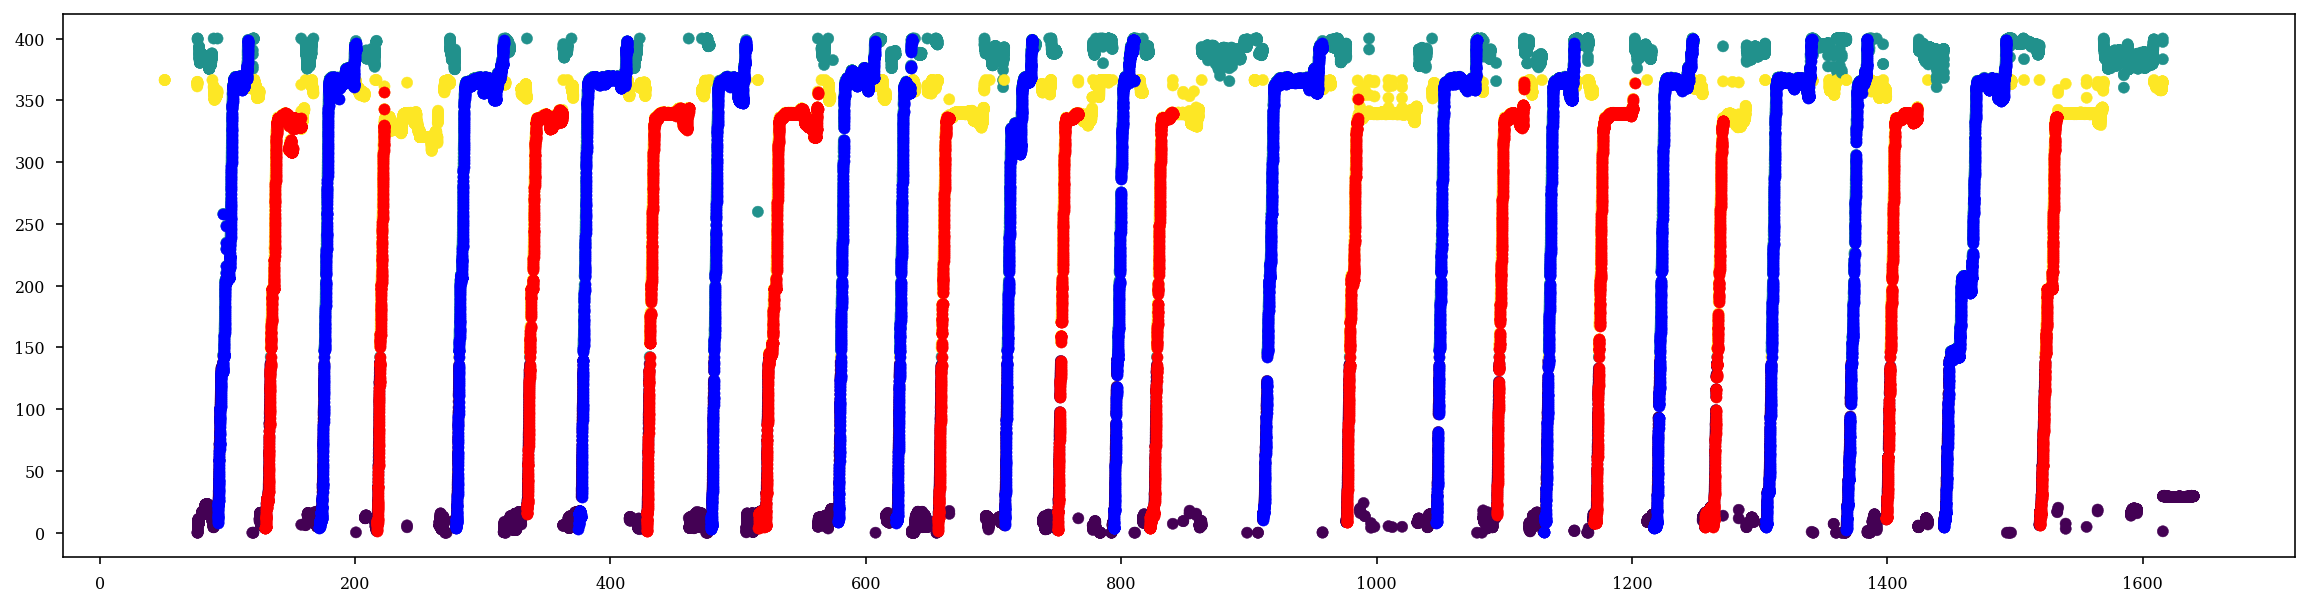

In [111]:
plt.figure(figsize=(20,5))
plt.scatter(
    position_df.query("epochs=='trial_1'").timestamps,
    position_df.query("epochs=='trial_1'").linearized,
    c=position_df.query("epochs=='trial_1'").states,
)
# plt.show()

outbound_epochs, inbound_epochs = functions.get_linear_track_lap_epochs(
    position_df.query("epochs=='trial_1'").timestamps, position_df.query("epochs=='trial_1'").linearized, newLapThreshold=20
)
pos = nel.PositionArray(
    data=position_df.query("epochs=='trial_1'")["linearized"].values.T,
    timestamps=position_df.query("epochs=='trial_1'").timestamps.values,
)
states = nel.AnalogSignalArray(data=position_df.query("epochs=='trial_1'")["states"].values.T,
    timestamps=position_df.query("epochs=='trial_1'").timestamps.values)

outbound_epochs = functions.find_good_lap_epochs(pos, outbound_epochs)
inbound_epochs = functions.find_good_lap_epochs(pos, inbound_epochs)

lap_id = dissociate_laps_by_states(states, outbound_epochs, states_of_interest=[1,2])
right_epochs = nel.EpochArray(data=outbound_epochs.data[lap_id==1,:])
left_epochs = nel.EpochArray(data=outbound_epochs.data[lap_id==2,:])

# plt.figure(figsize=(20,5))
plt.scatter(
    pos[right_epochs].abscissa_vals,
    pos[right_epochs].data[0].T,
    color="b"
)
plt.scatter(
    pos[left_epochs].abscissa_vals,
    pos[left_epochs].data[0].T,
    color="r"
)
right_epochs,left_epochs

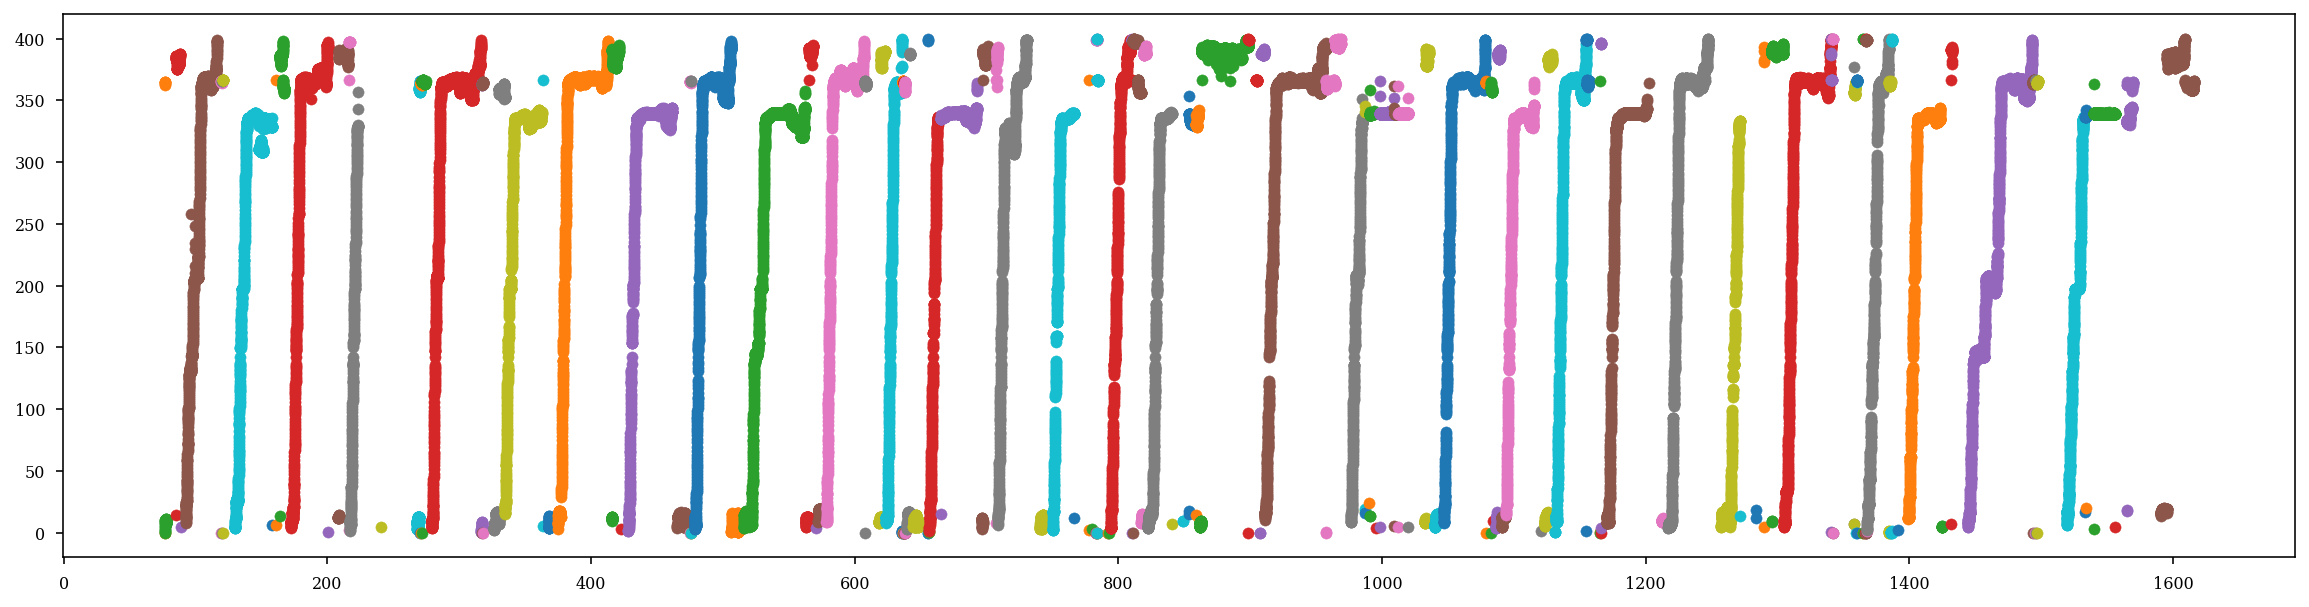

In [49]:
import logging
logging.getLogger().setLevel(logging.ERROR)
plt.figure(figsize=(20,5))

for ep in outbound_epochs:
    plt.scatter(
        pos[ep].abscissa_vals,
        pos[ep].data[0].T,
    )

In [ ]:
for basepath in epoch_df.query("environment == 'tmaze' & (mec|pfc)").basepath.unique():
    epoch_df_current = loading.load_epoch(basepath)

    startTime = epoch_df_current[epoch_df_current.environment == 'tmaze'].startTime
    stopTime = epoch_df_current[epoch_df_current.environment == 'tmaze'].stopTime

    position_df = loading.load_animal_behavior(basepath)
    try:
        position_df.timestamps 
    except:
        continue
    idx = (position_df.timestamps > startTime.iloc[0]) & (position_df.timestamps < stopTime.iloc[0])
    plt.plot(position_df[idx].x,position_df[idx].y)
    plt.axis("equal")
    plt.title(basepath)
    plt.show()    

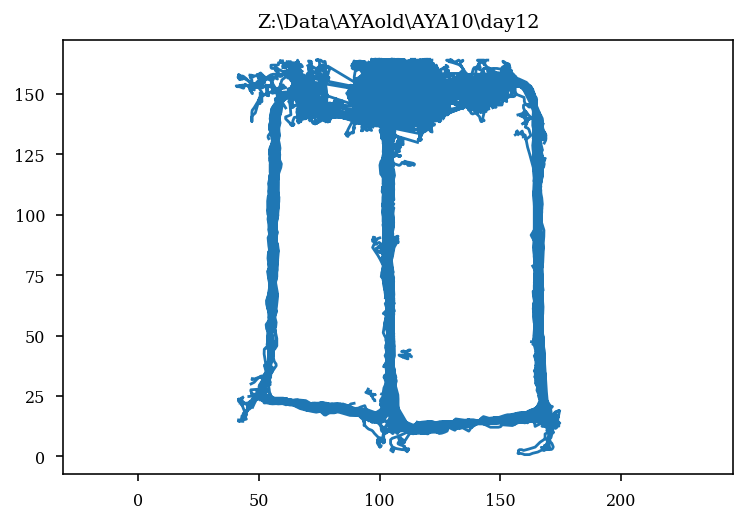

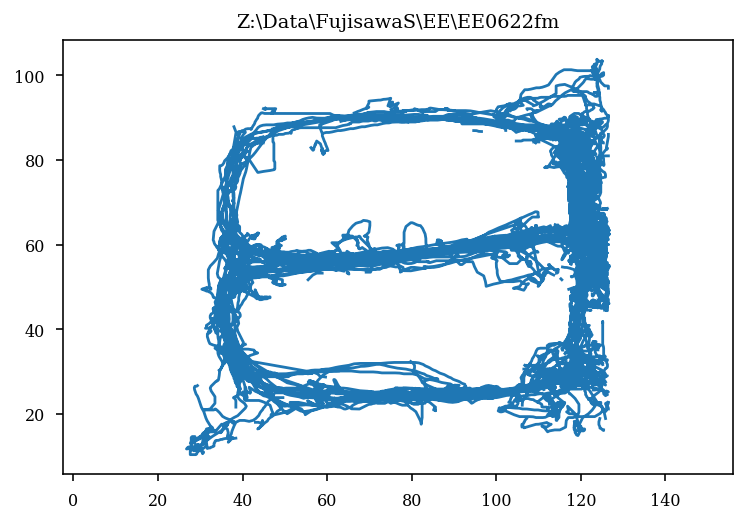

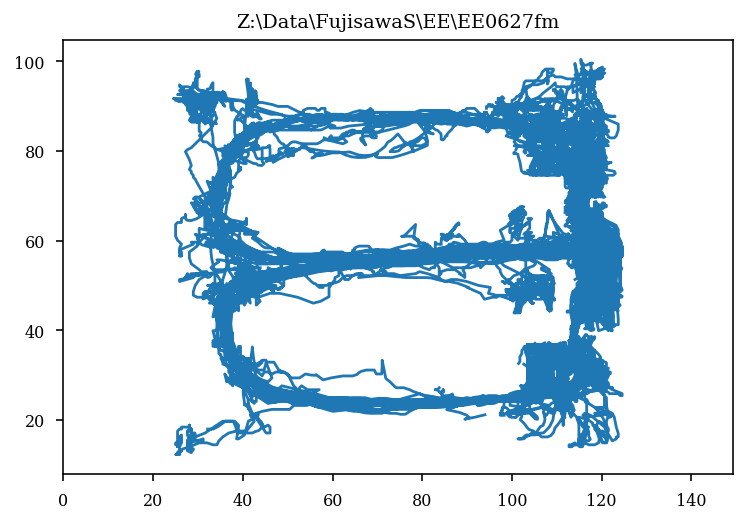

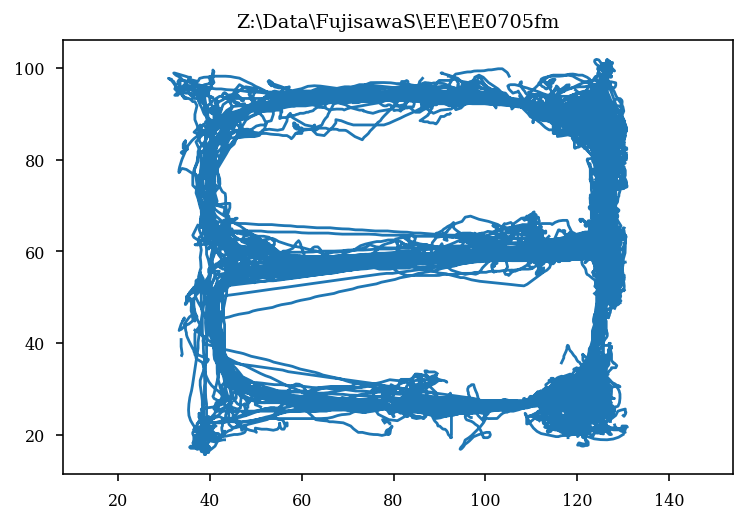

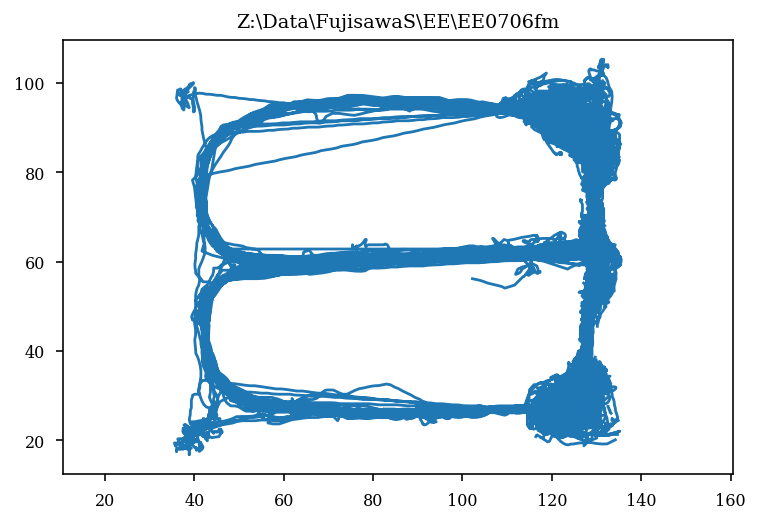

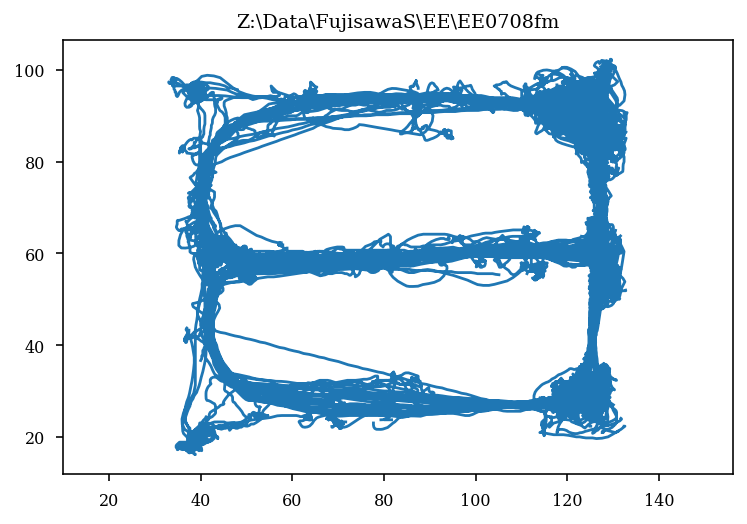

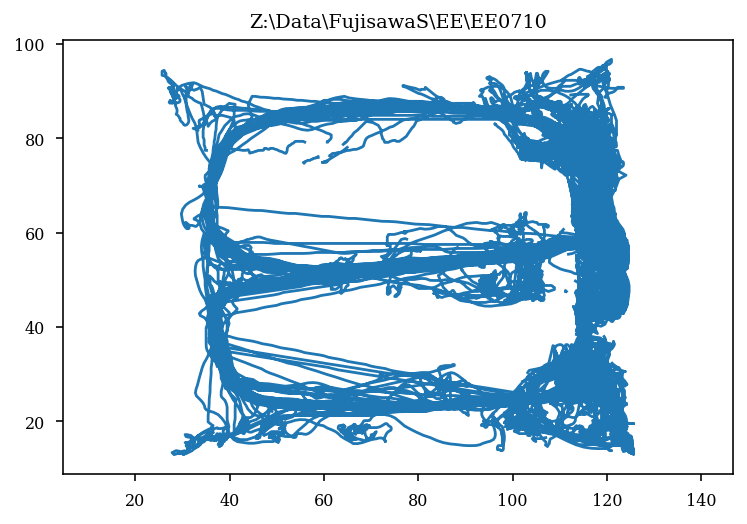

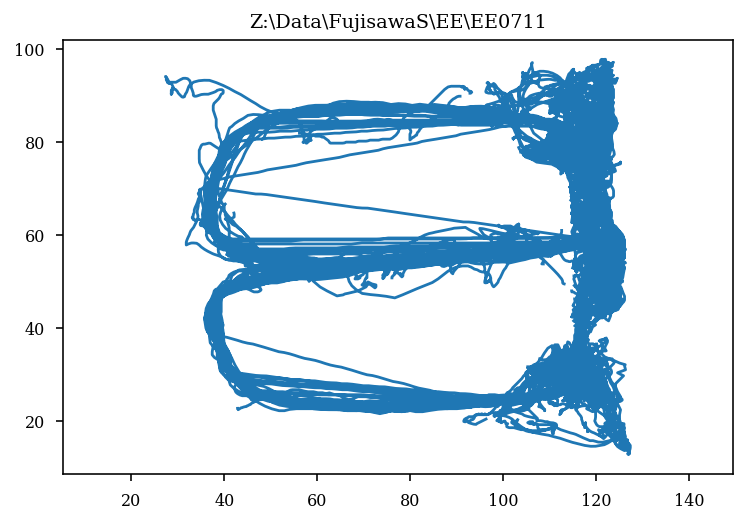

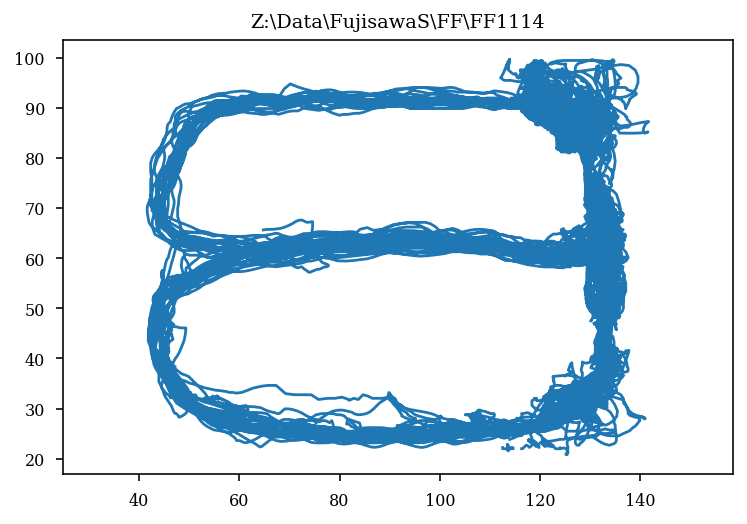

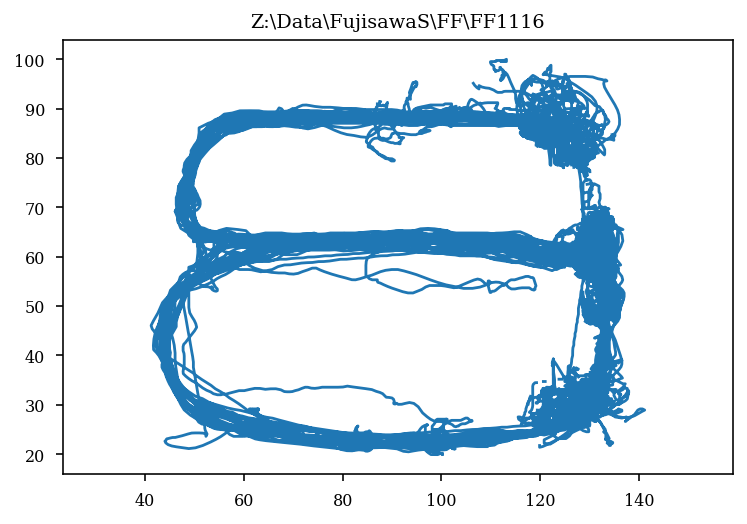

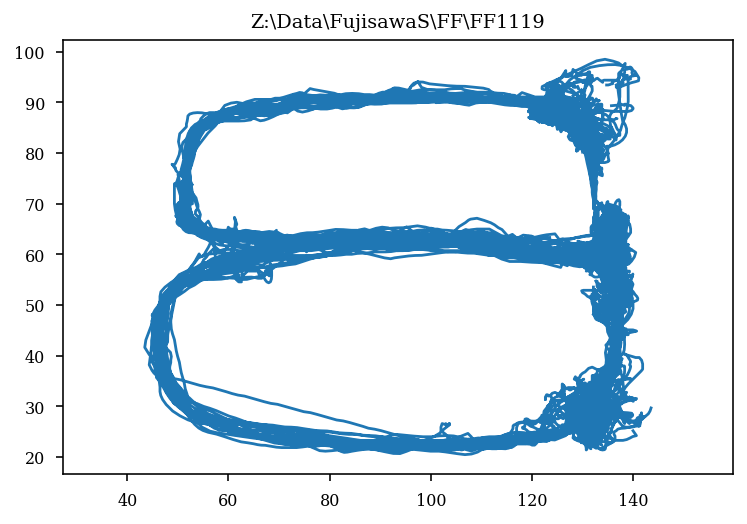

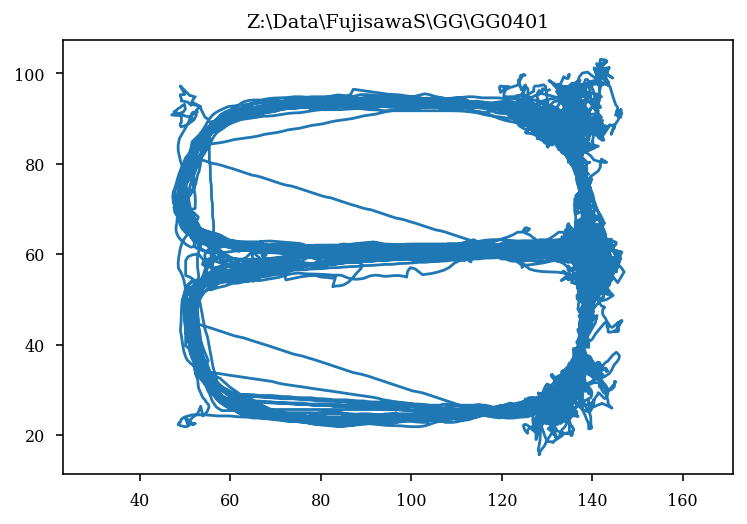

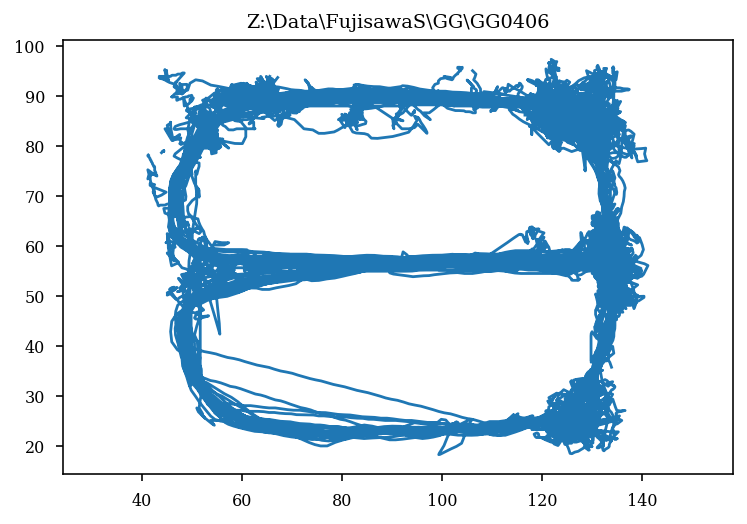

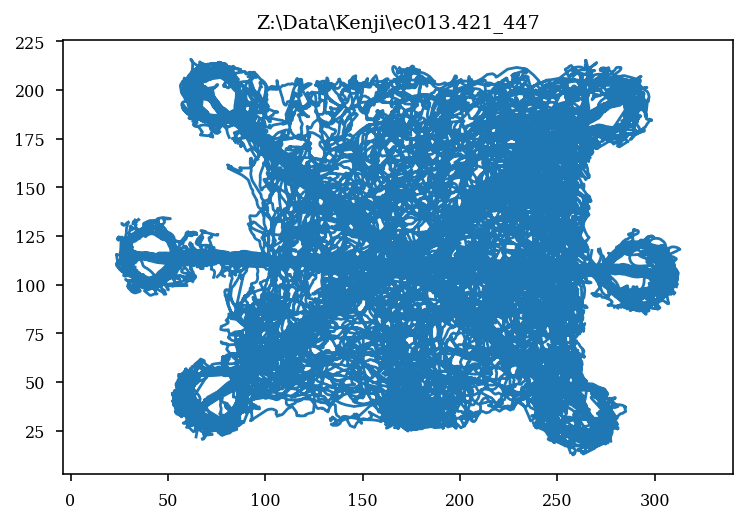

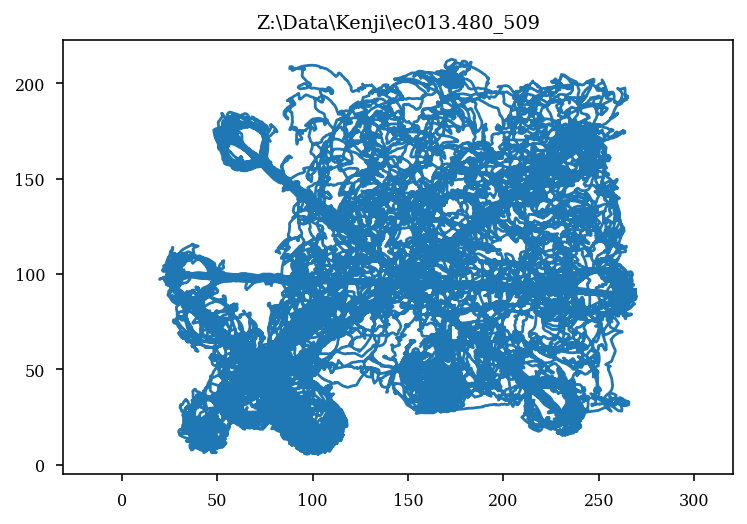

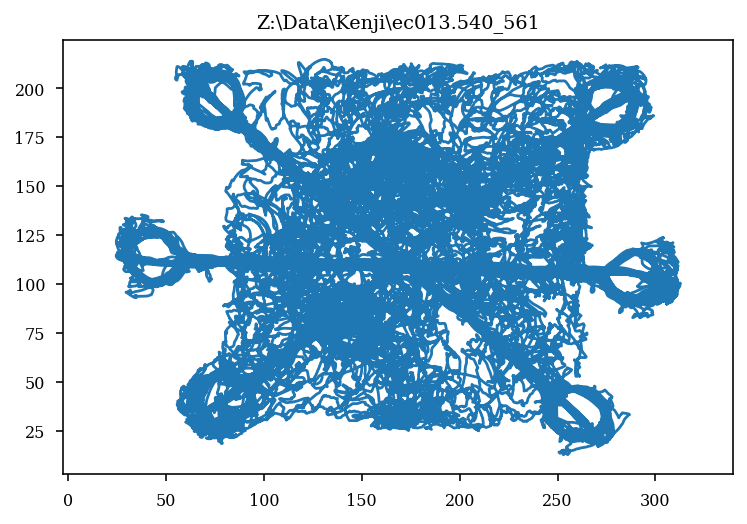

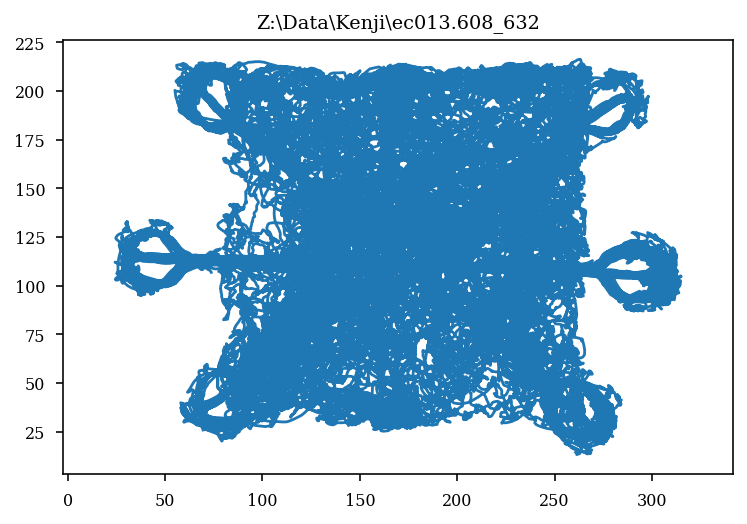

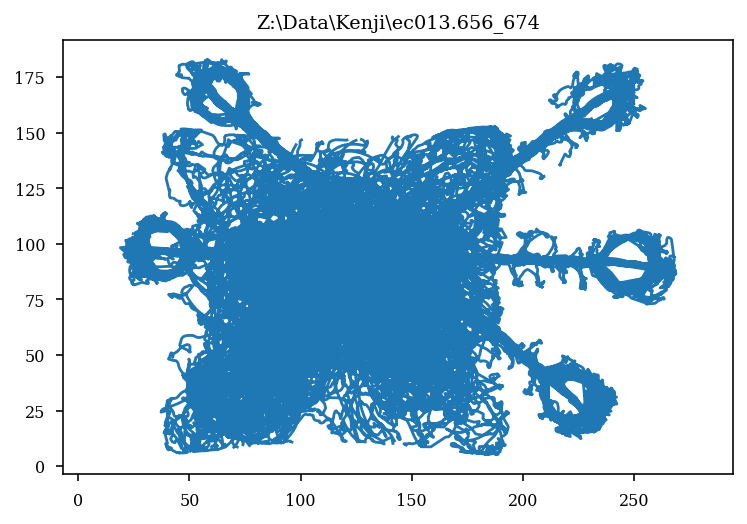

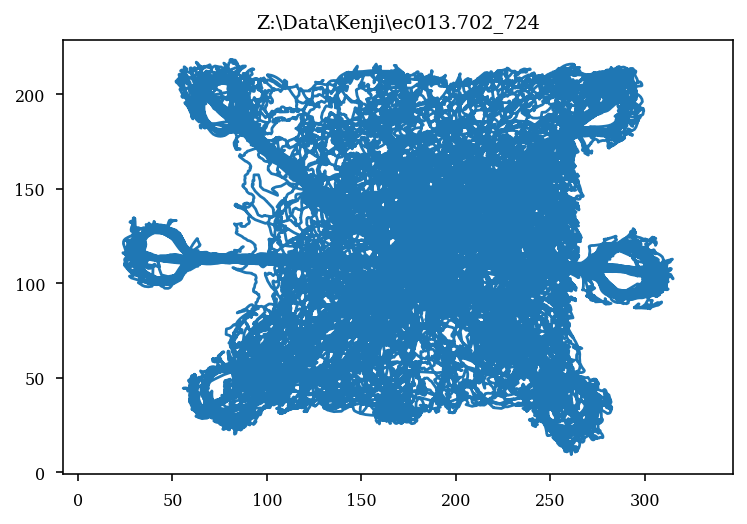

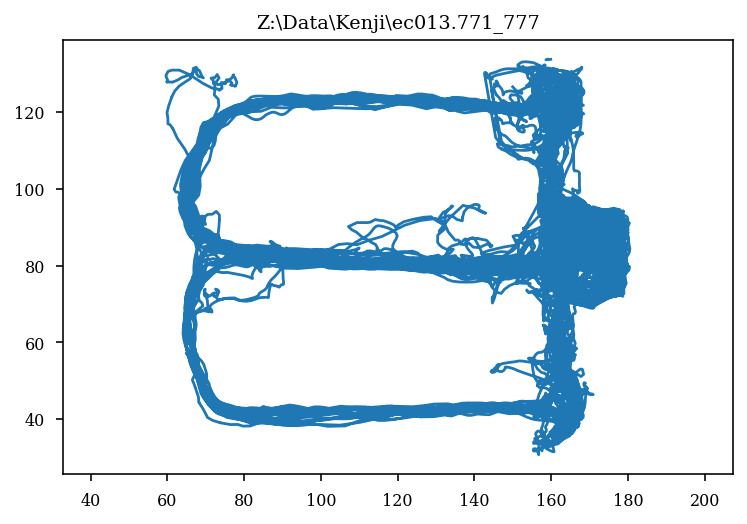

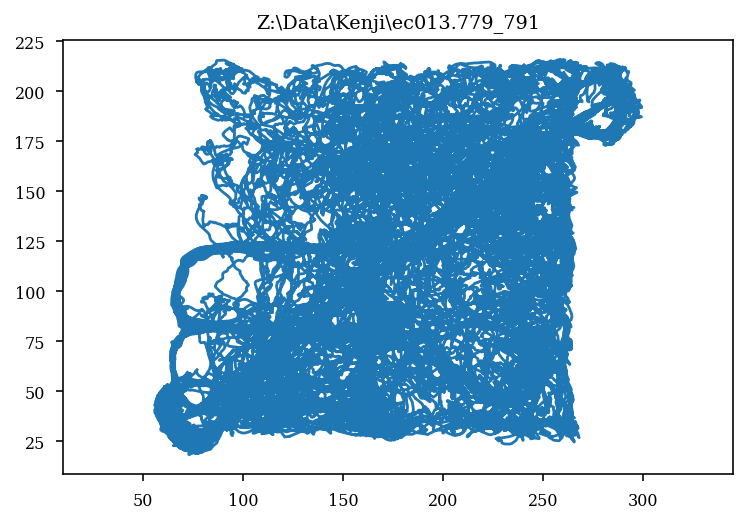

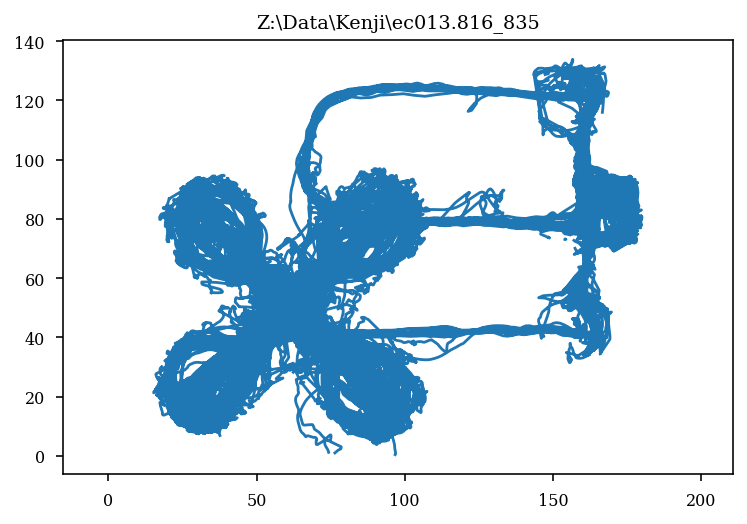

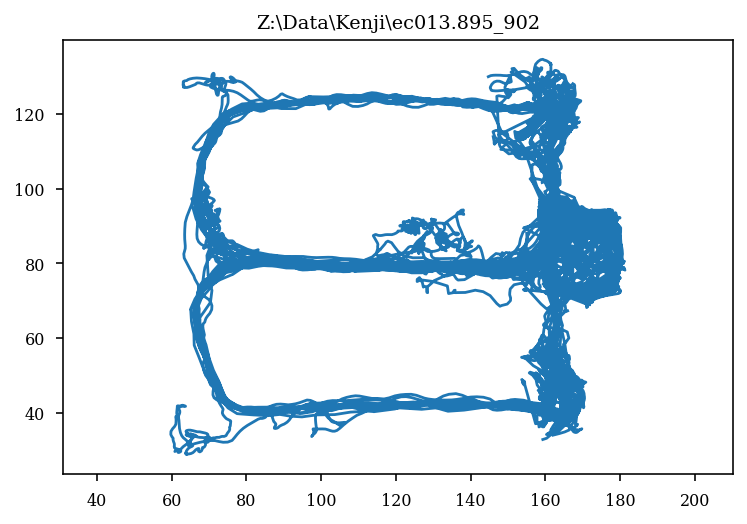

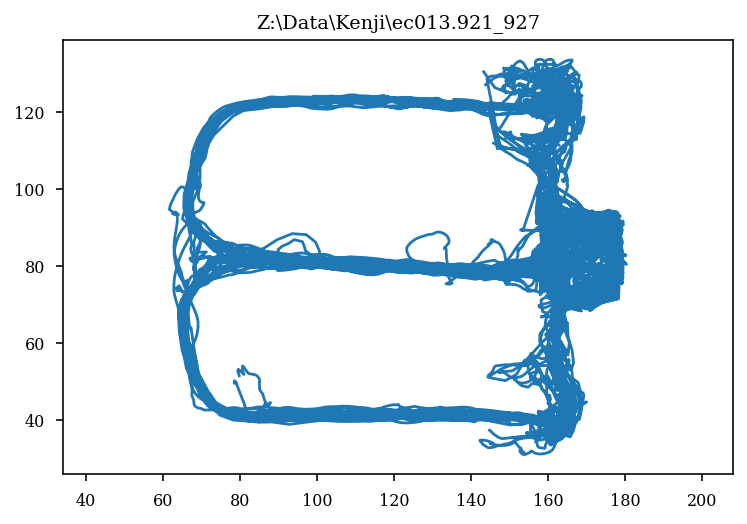

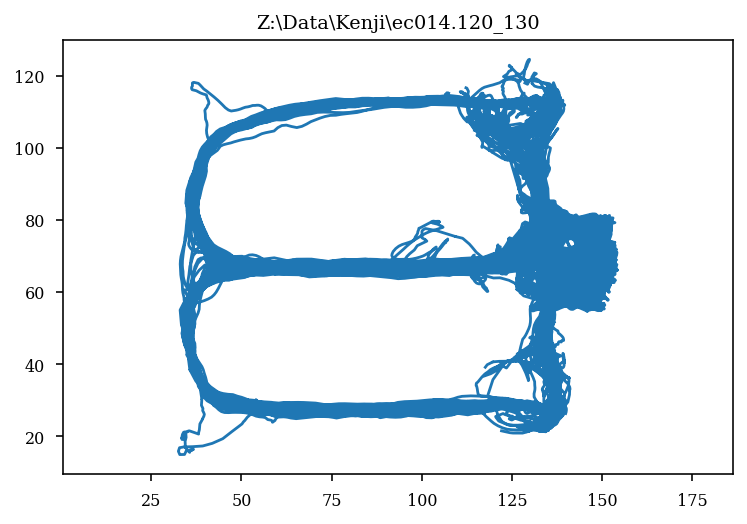

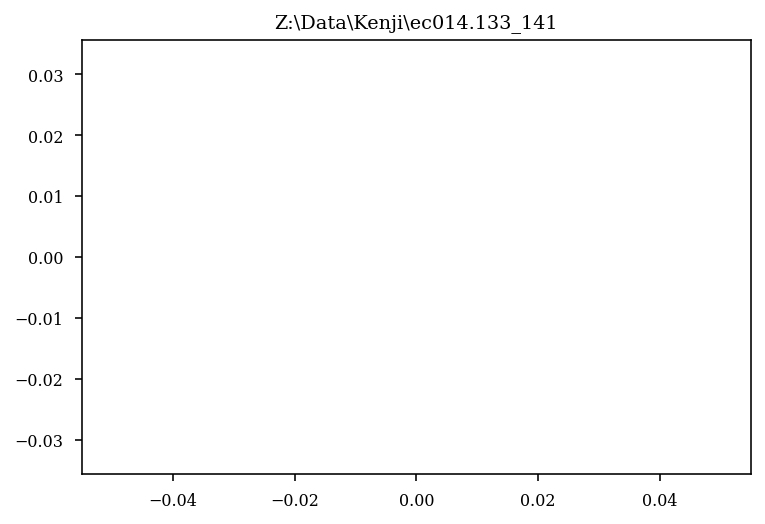

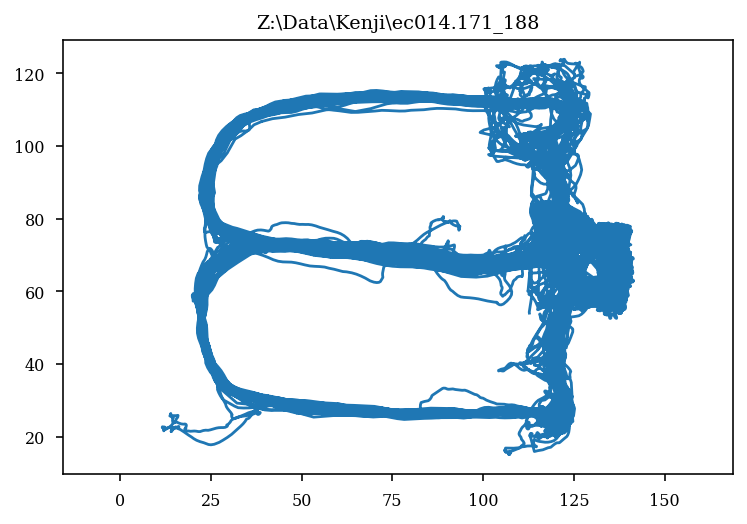

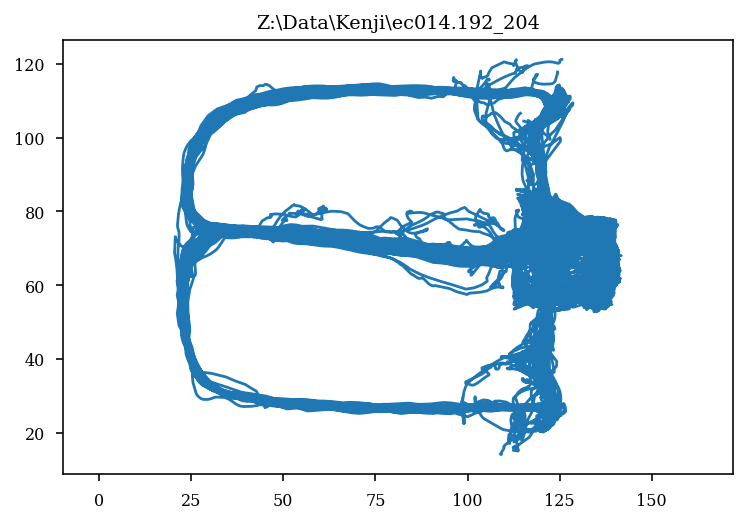

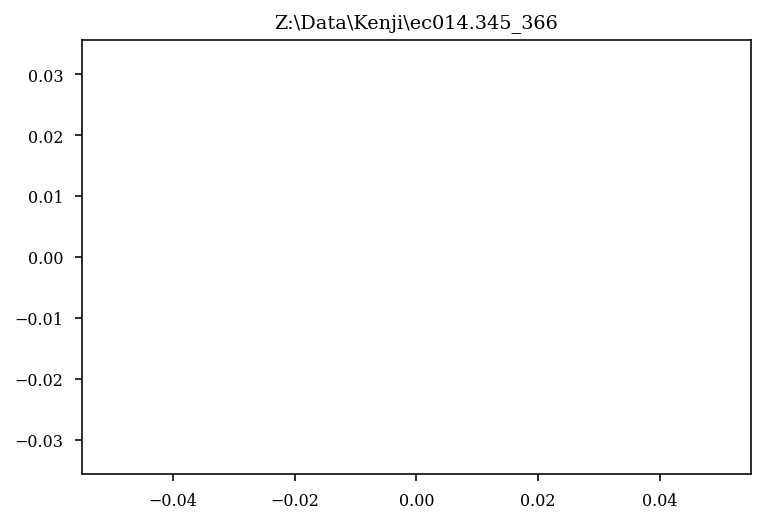

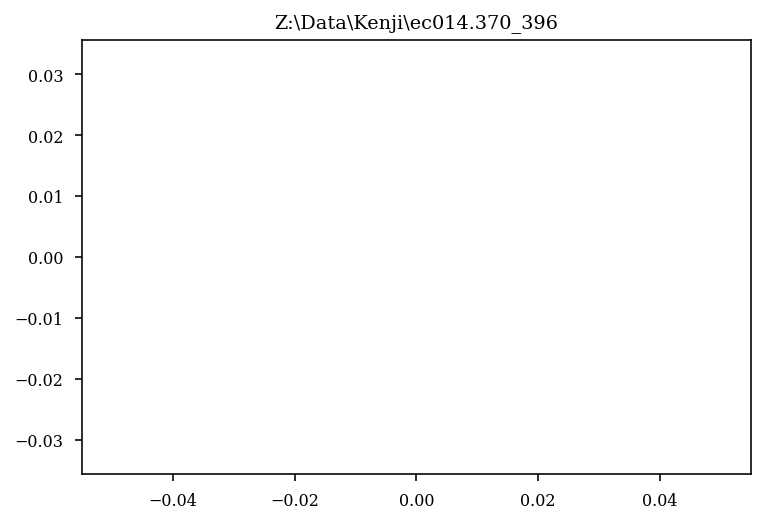

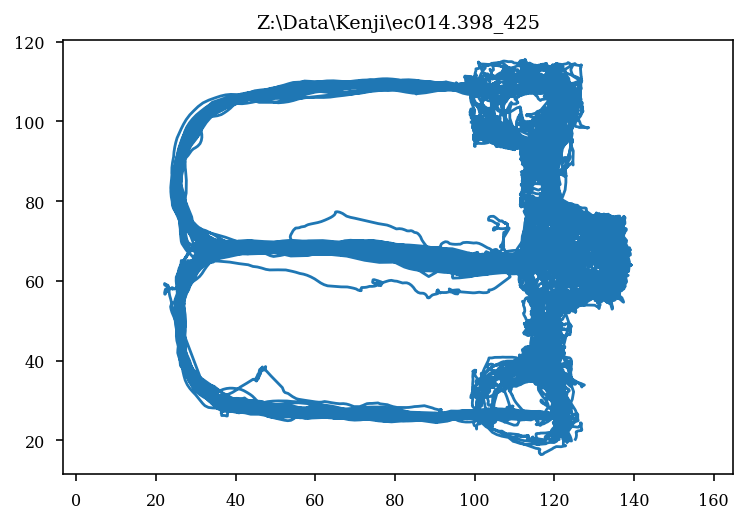

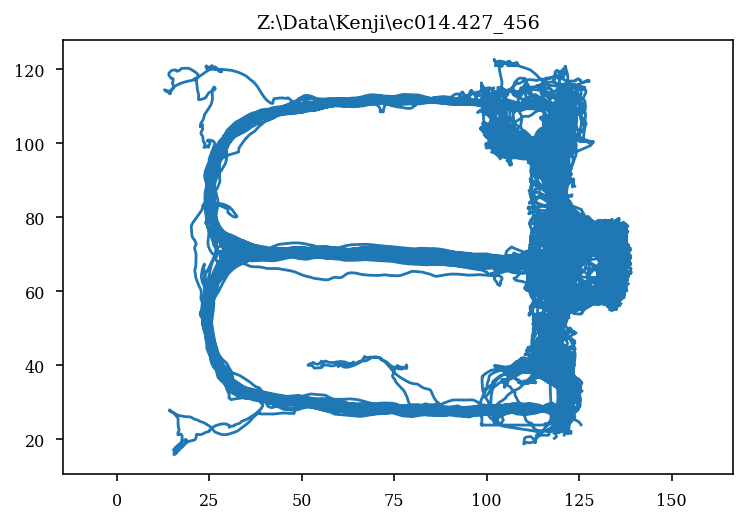

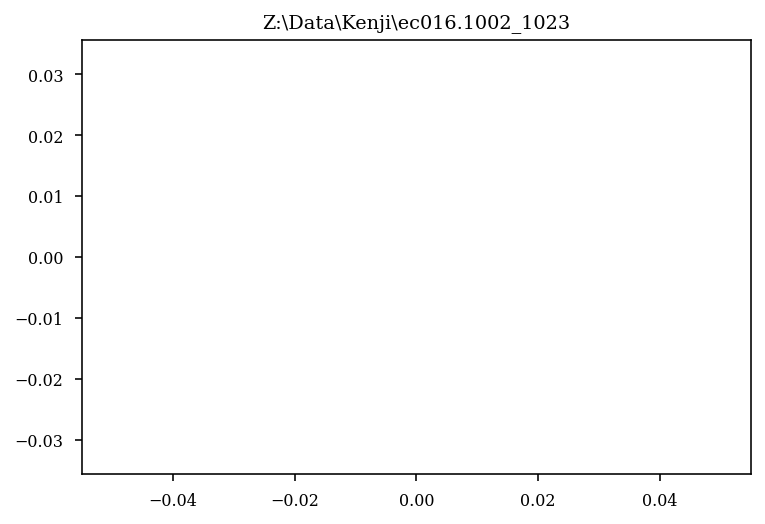

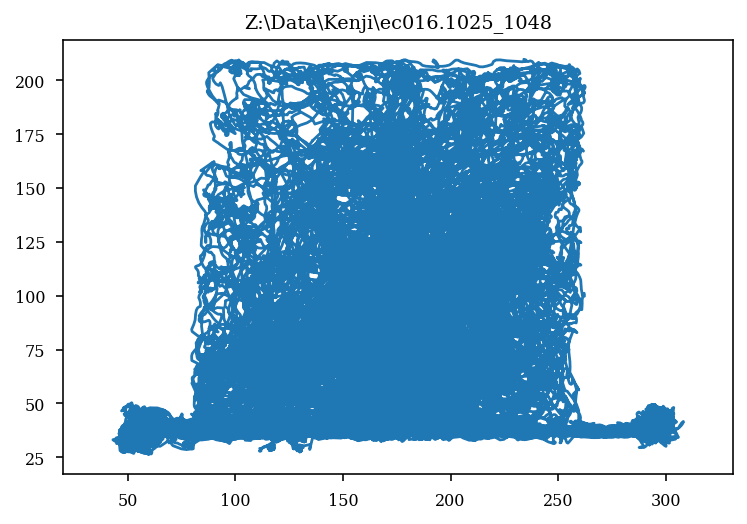

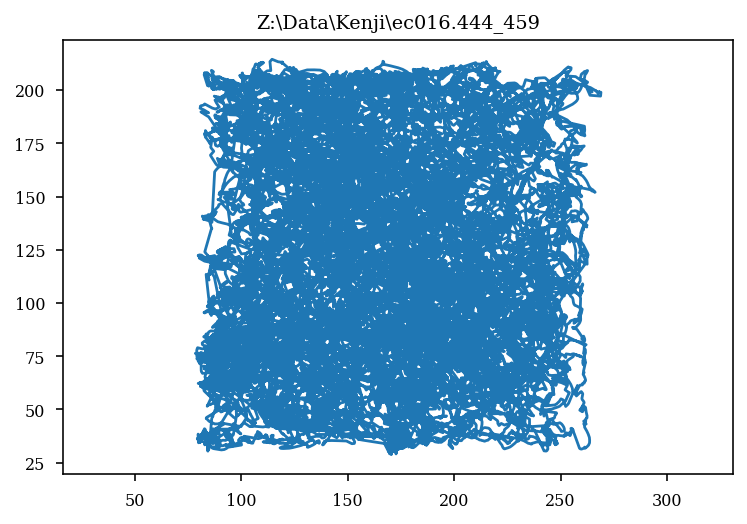

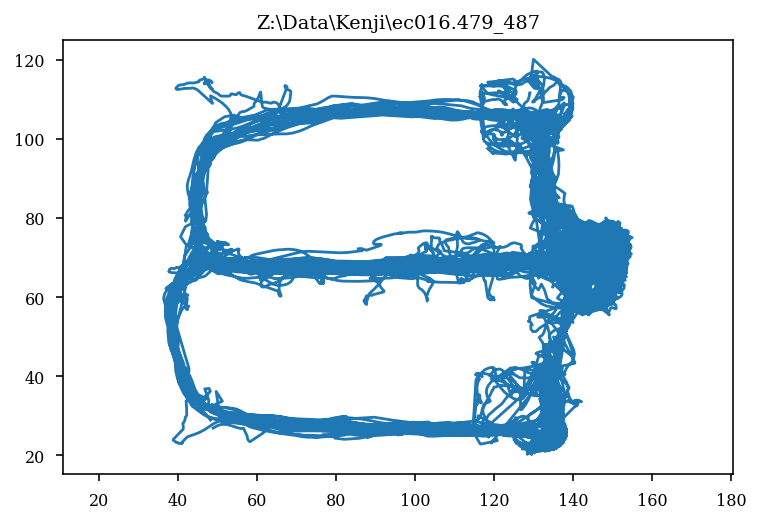

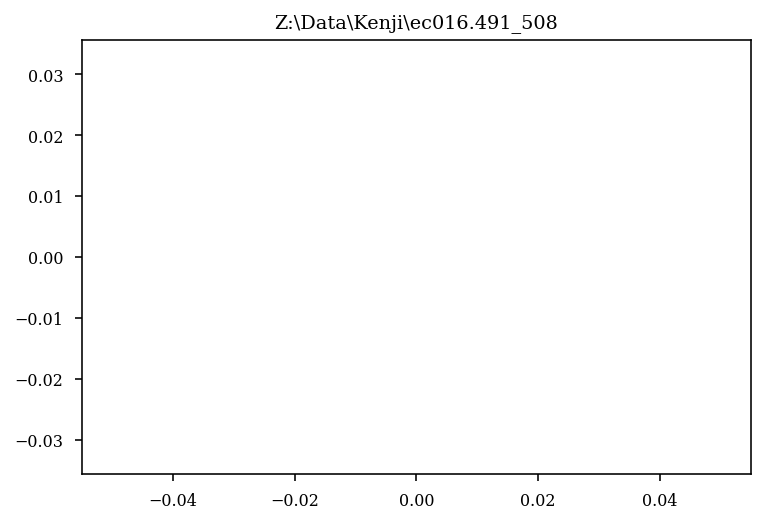

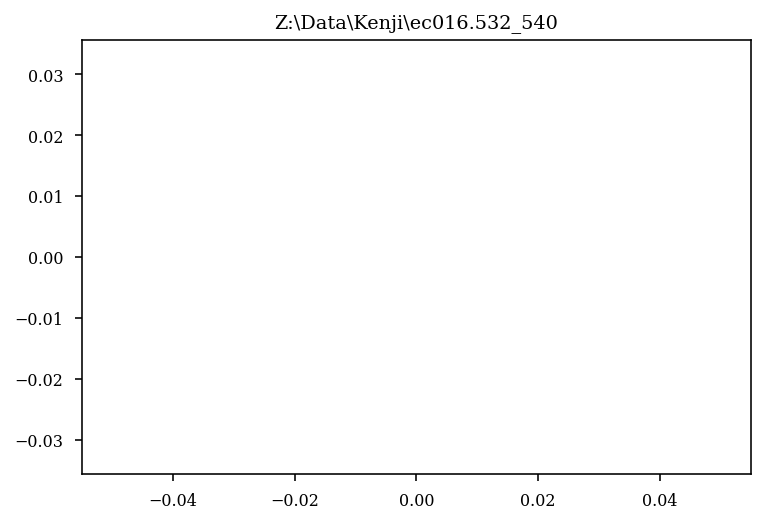

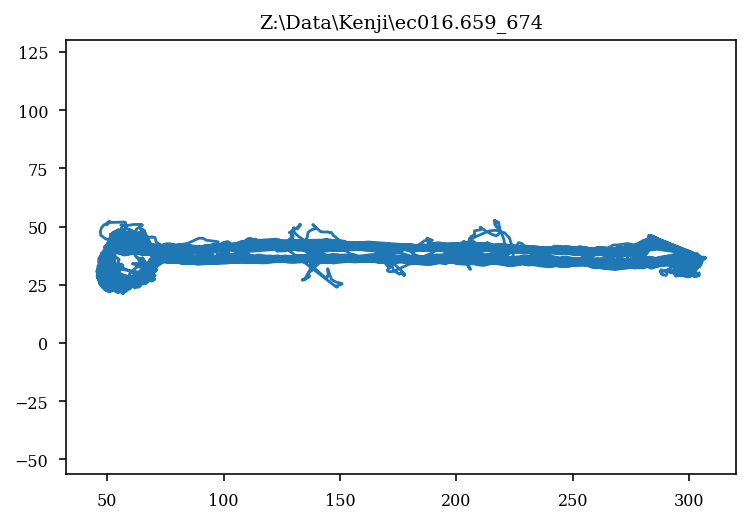

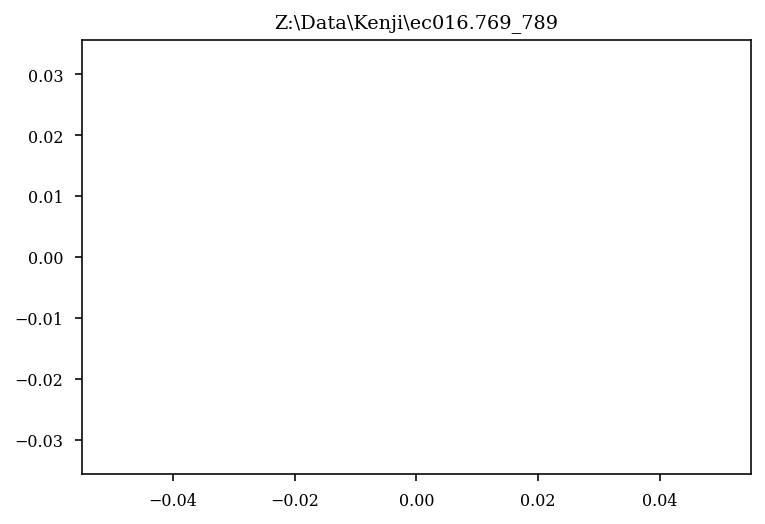

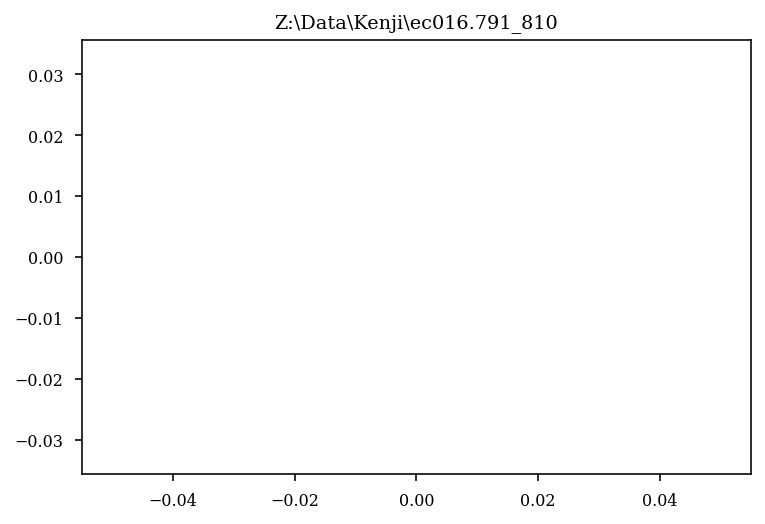

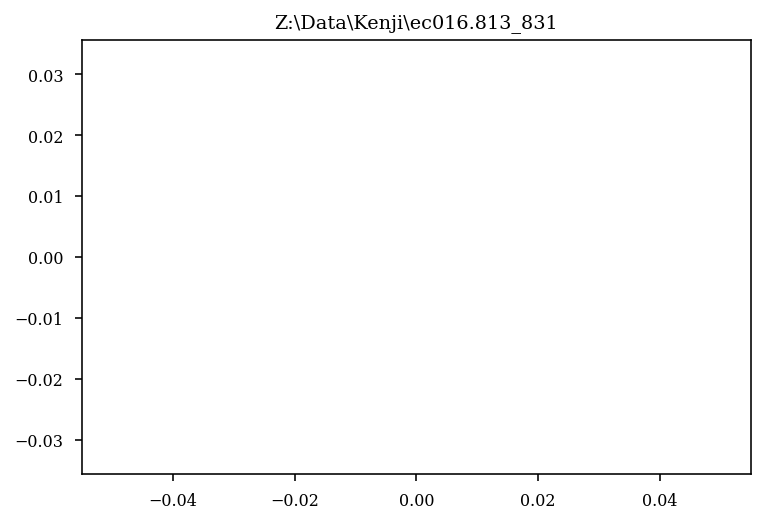

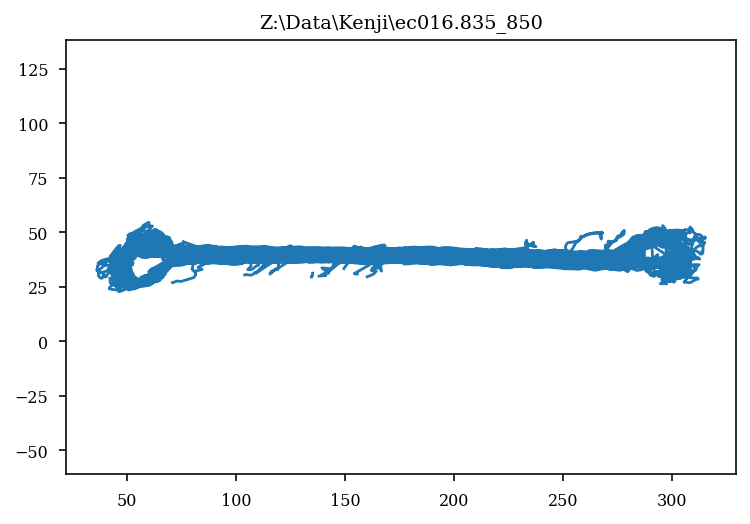

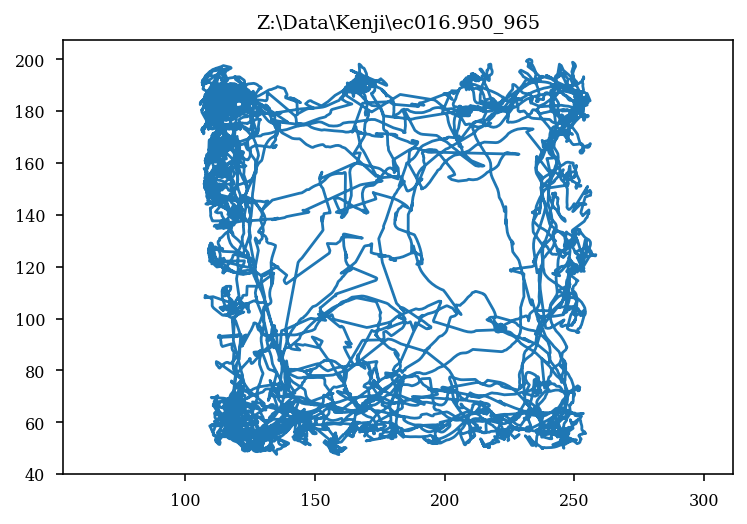

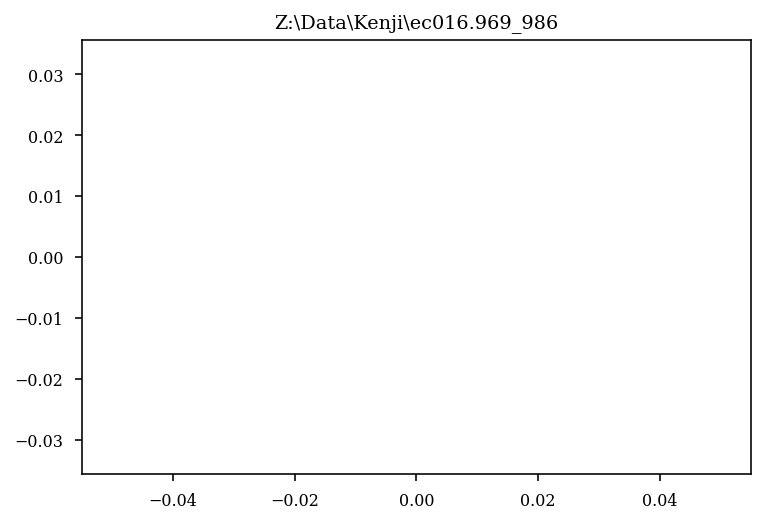

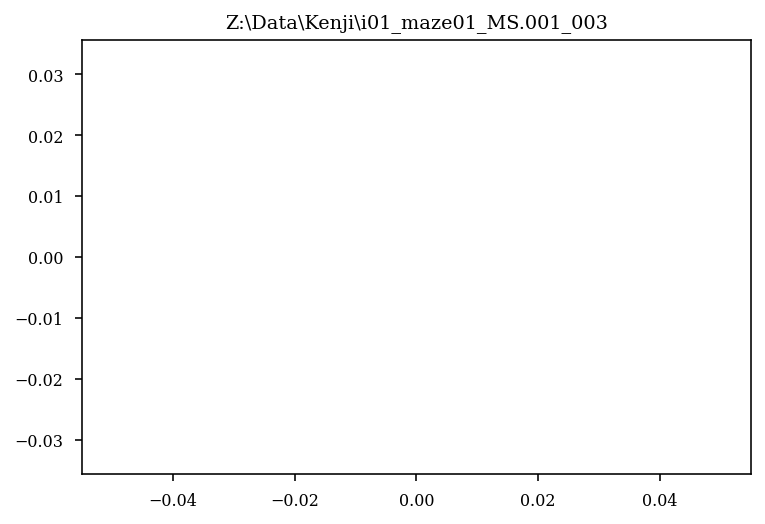

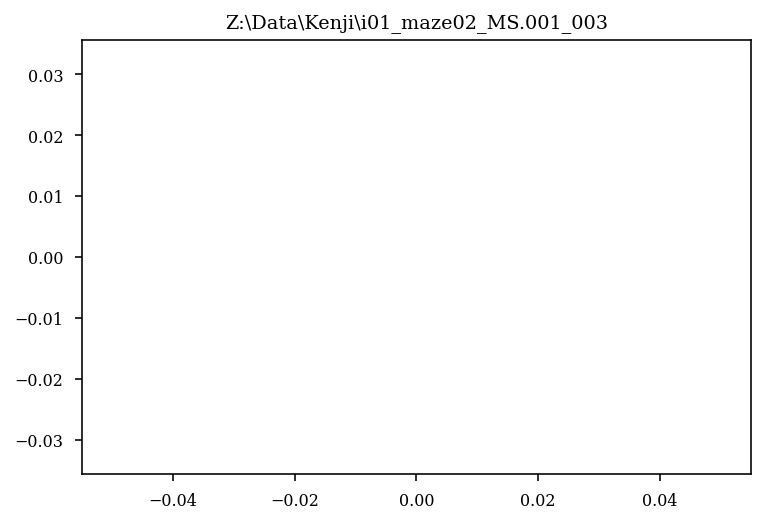

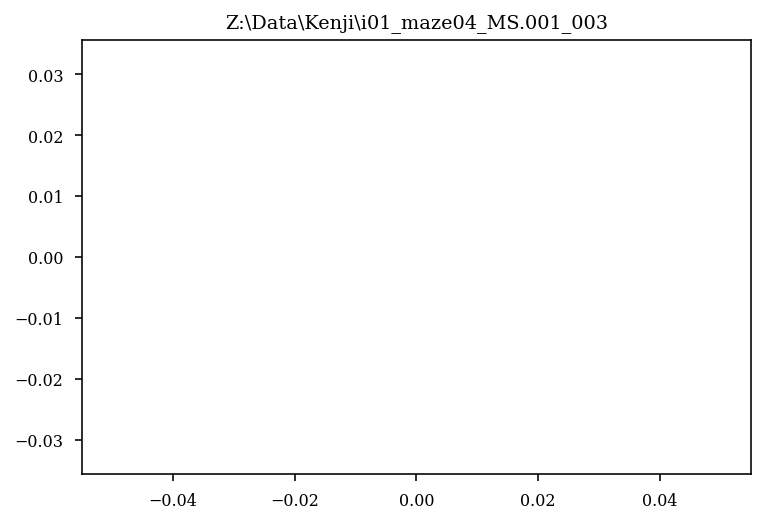

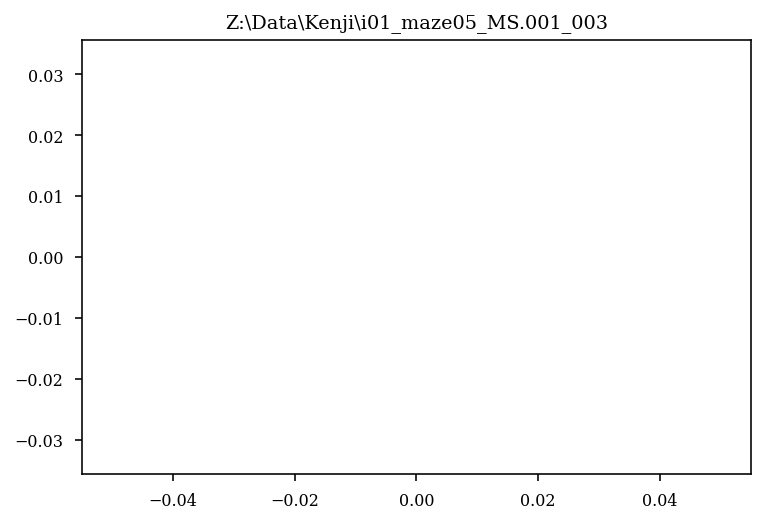

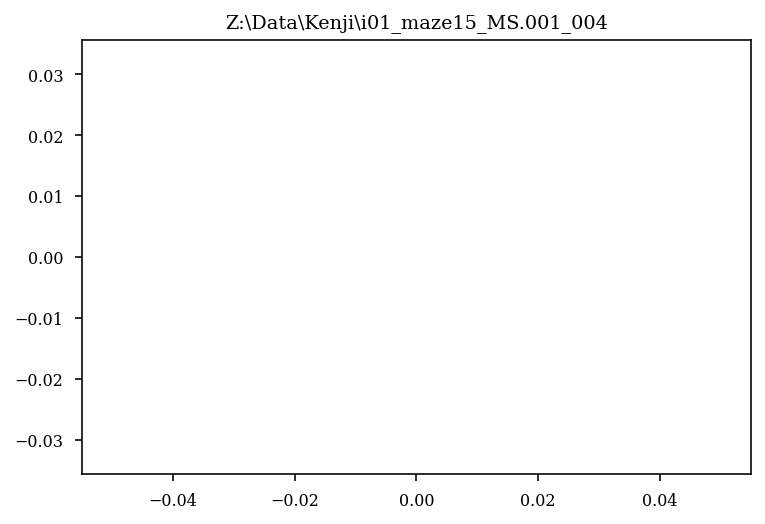

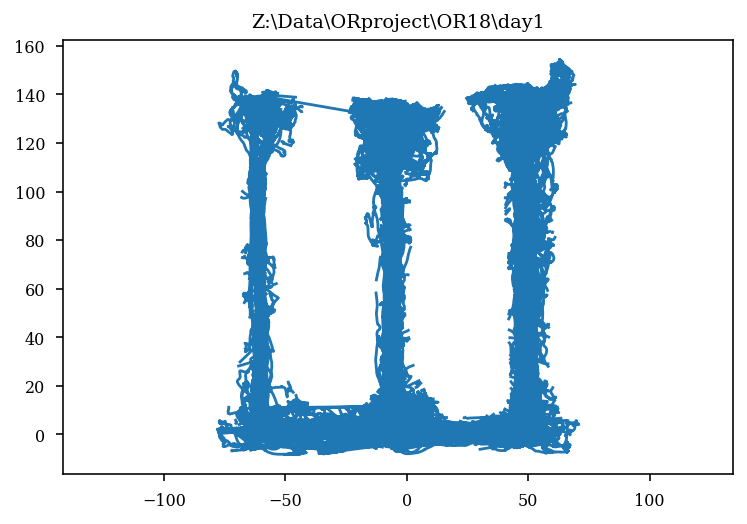

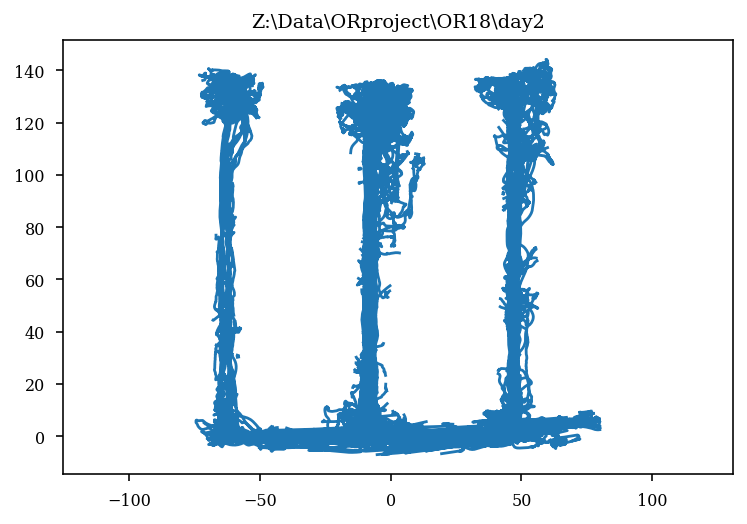

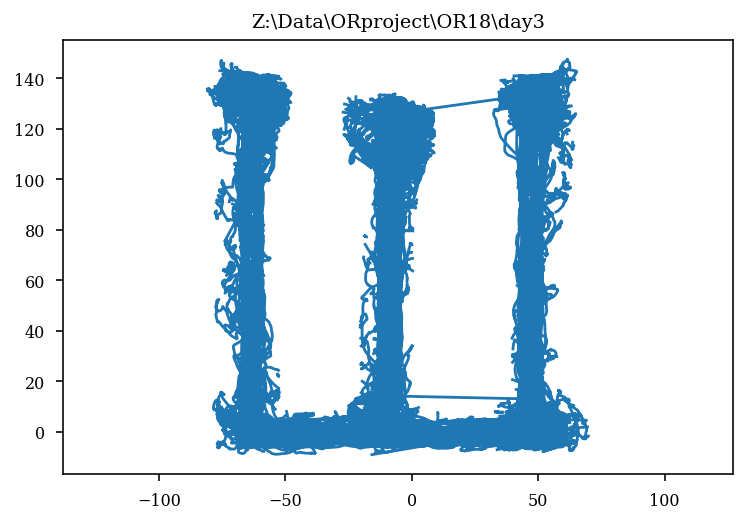

In [5]:
for basepath in epoch_df.query("environment.str.contains('Mwheel|Tmaze|tmaze|wmaze') & (mec|pfc)").basepath.unique():
    position_df = loading.load_animal_behavior(basepath)
    plt.plot(position_df.x,position_df.y)
    plt.axis("equal")
    plt.title(basepath)
    plt.show()    